In [1]:
import json

In [2]:
import re

In [3]:
import datetime

In [4]:
import pandas as pd

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Preparing

On the QFX it's needed to configure service analytics for sending queue and traffic information about interested interfaces

In my case it was
<pre>
set services analytics export-profiles analysis stream-format json
set services analytics export-profiles analysis interface information
set services analytics export-profiles analysis interface statistics traffic
set services analytics export-profiles analysis interface statistics queue 
set services analytics resource-profiles analysis queue-monitoring
set services analytics resource-profiles analysis traffic-monitoring
set services analytics resource system polling-interval traffic-monitoring 2
set services analytics resource system polling-interval queue-monitoring 1000
set services analytics resource interfaces xe-0/0/14 resource-profile analysis
set services analytics resource interfaces xe-0/0/39 resource-profile analysis
set services analytics collector address 85.112.118.20 port 50384 transport udp export-profile analysis
</pre>

So then it's needed to receive the information. 

On the target machine I grabed data with tcpdump and save it to the pcap file
<pre>
$ tcpdump -i en0 -n port 50384  -w - -p -s 0 > ~/Desktop/m9-sw39_new.pcap
</pre>

Then in wireshark I just saved the file with JSON format:
<pre>
File —> Export Packet Dissections -> As JSON...
</pre>

And in the final I get file m9-sw39_new_2.json which I'll process in further

## Functions for parse packets

Here are a few functions for parsing json

In [6]:
get_time = lambda x: x['_source']['layers']['frame']['frame.time']

In [7]:
get_data = lambda x: x['_source']['layers']['data']['data.data']

In [8]:
get_json_str = lambda x : re.sub('(\n|\x00)','',bytes.fromhex(x.replace(':','')).decode('utf8'))

In [9]:
get_json_data = lambda x: json.loads(get_json_str(get_data(x)))

In [10]:
get_time_from_data = lambda x: datetime.datetime.fromtimestamp(int(str(x)[:10]))

# Start parsing

## Open file with dump and export to the json object (in our case it's a list)

In [11]:
with open('m9-sw39_new_2.json','r') as f:
    sw39 = json.load(f)

## Parse to PandasDataframe object

In [12]:
only_data = [get_json_data(x) for x in sw39 if x['_source']['layers'].get('data')]

# Plot graphs with traffic-stats: txpbs, rxbps and txdroppkt

### Preparing

In [13]:
traffic_stats_raw = [x for x in only_data if x['record-type'] == 'traffic-stats']

In [14]:
traffic_stats = pd.DataFrame(traffic_stats_raw)

In [15]:
traffic_stats.time = traffic_stats.time.apply(get_time_from_data)

In [16]:
traffic_stats.index = traffic_stats.time

In [17]:
traffic_stats_14 = traffic_stats[traffic_stats.port == 'xe-0/0/14']
traffic_stats_39 = traffic_stats[traffic_stats.port == 'xe-0/0/39']

### Plot 14 port

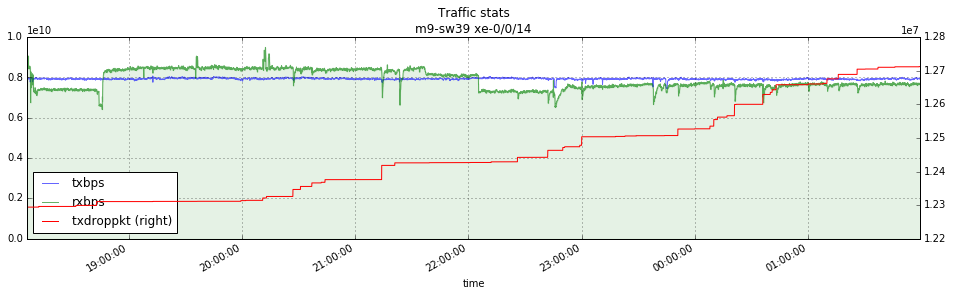

In [18]:
fig = plt.figure(figsize=(16,4))
traffic_stats_14.txbps.plot(legend=True, alpha=0.6, color='blue')
traffic_stats_14.rxbps.plot(legend=True, alpha=0.6, color='green')
plt.fill_between(traffic_stats_14.index, traffic_stats_14.rxbps, alpha=0.1, color='green')
traffic_stats_14.txdroppkt.plot(secondary_y=True, legend=True, color='red', grid=True)
plt.title('Traffic stats\nm9-sw39 xe-0/0/14')
plt.show()

### 39 port

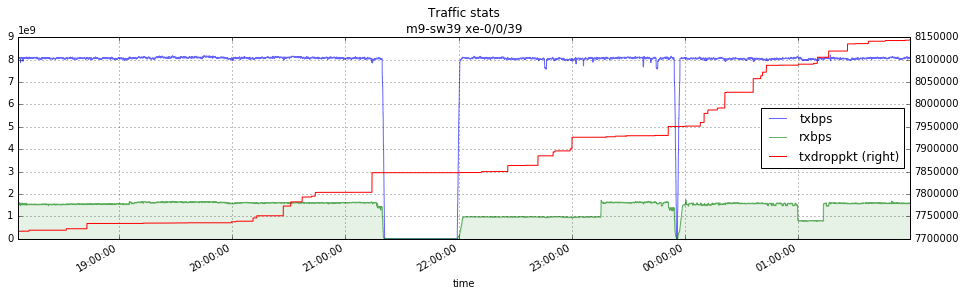

In [19]:
fig = plt.figure(figsize=(16,4))
traffic_stats_39.txbps.plot(alpha=0.6, color='blue', legend = True)
traffic_stats_39.rxbps.plot(alpha=0.6, color='green', legend = True)
plt.fill_between(traffic_stats_39.index,traffic_stats_39.rxbps,alpha=0.1, color='green')
traffic_stats_39.txdroppkt.plot(secondary_y=True, color='red', legend = True, grid= True)
plt.title('Traffic stats\nm9-sw39 xe-0/0/39')
plt.show()

## Plot only changes of txdroppkt

### 39 port

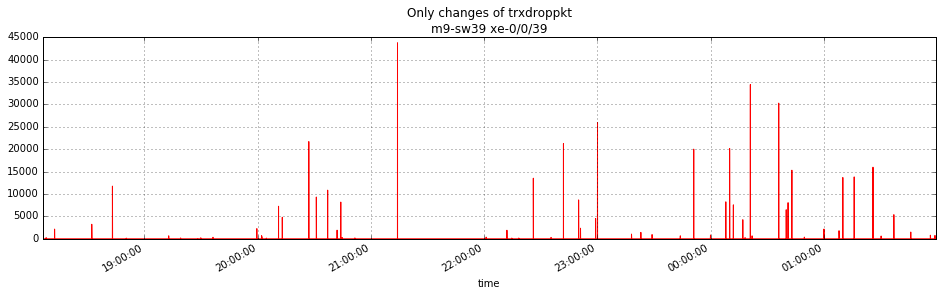

In [20]:
plt.figure(figsize=(16,4))
traffic_stats_39.txdroppkt.diff().plot(color='red')
plt.title('Only changes of trxdroppkt\nm9-sw39 xe-0/0/39')
plt.grid(True)

### 14 port

the same!

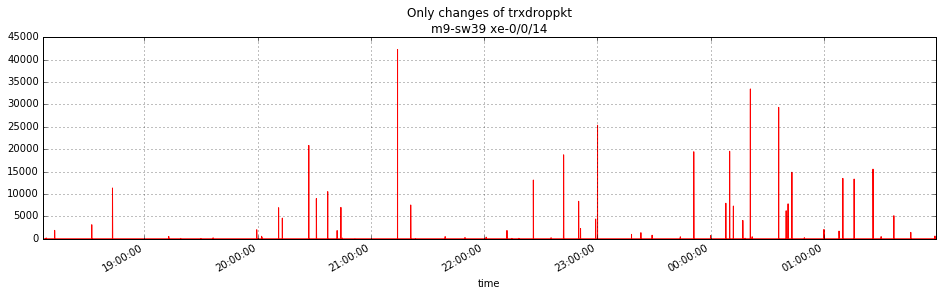

In [21]:
plt.figure(figsize=(16,4))
traffic_stats_14.txdroppkt.diff().plot(color='red')
plt.title('Only changes of trxdroppkt\nm9-sw39 xe-0/0/14')
plt.grid(True)

## Queue_stats with txdroppkt

In [22]:
queue_stats_raw = [x for x in only_data if x['record-type'] == 'queue-stats']

In [23]:
queue_stats = pd.DataFrame(queue_stats_raw)

In [24]:
queue_stats.time = queue_stats.time.apply(get_time_from_data)

In [25]:
queue_stats.index = queue_stats.time

In [26]:
queue_14 = queue_stats[queue_stats.port == 'xe-0/0/14']
queue_39 = queue_stats[queue_stats.port == 'xe-0/0/39']

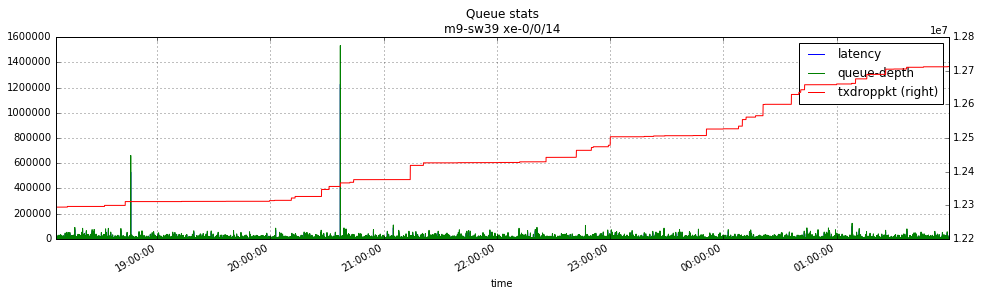

In [27]:
fig = plt.figure(figsize=(16,4))
queue_14.latency.plot(legend=True)
queue_14['queue-depth'].plot(legend=True)
traffic_stats_14.txdroppkt.plot(secondary_y=True, legend=True, grid=True)
plt.title('Queue stats\nm9-sw39 xe-0/0/14')
plt.show()

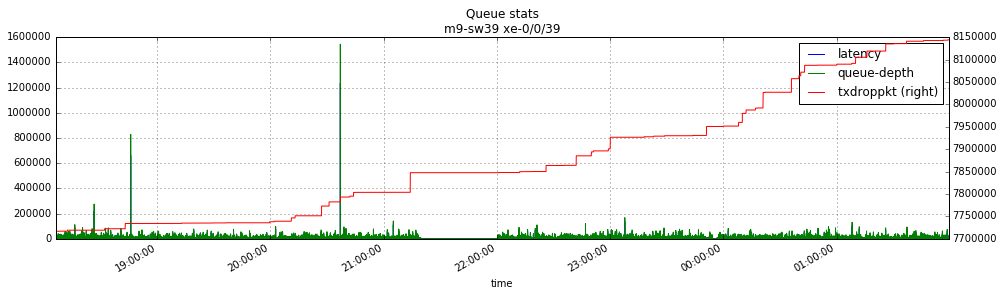

In [28]:
fig = plt.figure(figsize=(16,4))
queue_39.latency.plot(legend=True)
queue_39['queue-depth'].plot(legend=True)
traffic_stats_39.txdroppkt.plot(secondary_y=True, legend=True, grid=True)
plt.title('Queue stats\nm9-sw39 xe-0/0/39')
plt.show()